In [1]:
# file data read and make the train/validation data sets
import os
import csv

samples = []
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)
#print(len(train_samples), len(validation_samples))

In [ ]:
# Augmented Dataset

In [ ]:
'''
augmented_images, augmented_measurements = [], []
for image, measurement in zip(images, measurements):
    augmented_images.append(image)
    augmented_measurements.append(measurement)
    augmented_images.append(cv2.flip(image,1))
    augmented_measurements.append(measurement * -1.0)
    
def augmented_data(images, steerings):
    augmented_images, augmented_steering = [], []
    for image, steering in zip(images, steerings):
        augmented_images.append(image)
        augmented_measurements.append(steering)
        augmented_images.append(cv2.flip(image,1))
        augmented_steering.append(steering * -1.0)
    return np.array(agumented_images), np.array(augmented_steering)
'''

In [6]:
# Generator
import cv2
import numpy as np
import sklearn
from sklearn.utils import shuffle

def data_flip(image, angle):
    return cv2.flip(image,1), angle*-1.0

def data_brightness(image, angle):
    img_tmp = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    img_tmp[:,:,2] = img_tmp[:,:,2] * np.random.uniform(0.1, 1.2)
    image = cv2.cvtColor(img_tmp, cv2.COLOR_HSV2RGB)
    return image, angle 

def random_augmented_data(image, angle):
    rand = np.random.randint(3)
    if rand == 0:      #horizontal flip
        image, angle = data_flip(image, angle)
    elif rand == 1: #brightness
        image, angle = data_brightness(image, angle)
    elif rand == 2: #flip & brightness
        tmp_img, tmp_angle = data_flip(image, angle)
        image, angle = data_brightness(tmp_img, tmp_angle)        
    return image, angle

def random_select_data(batch_sample, correction):
    rand = np.random.randint(3)
    name = './data/IMG/'+batch_sample[rand].split('/')[-1]
    image = cv2.imread(name)
    if  rand == 0:        # center
        correction = 0.0
    elif rand == 1:    # left
        correction = - correction
    elif rand == 2:    # right
        correction = correction        
    angle = float(batch_sample[3]) + correction
    return image, angle        

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            correction = 0.2
            images = []
            angles = []
            for batch_sample in batch_samples:
                angle_center = float(batch_sample[3])
                angle_left = angle_center + correction
                angle_right = angle_center - correction
                
                angles.append(angle_center)
                angles.append(angle_left)
                angles.append(angle_right)
                
                name = './data/IMG/'+batch_sample[0].split('/')[-1]
                image_center = cv2.imread(name)
                name = './data/IMG/'+batch_sample[1].split('/')[-1]
                image_left = cv2.imread(name)
                name = './data/IMG/'+batch_sample[2].split('/')[-1]
                image_right = cv2.imread(name)

                images.append(image_center)
                images.append(image_left)
                images.append(image_right)
                
                if (np.random.randint(2) == 0):  # 50% data add
                    tmp_img, tmp_ang = random_select_data(batch_sample, correction)
                    rnd_img, rnd_ang = random_augmented_data(tmp_img, tmp_ang)
                    images.append(rnd_img)
                    angles.append(rnd_ang)
                
            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            
            yield sklearn.utils.shuffle(X_train, y_train)
            
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

In [38]:
## Simple Code Test Area

num_samples= len(train_samples)
images, angles = [], []
for sample in train_samples:
    correction = 0.2
    angle_center = float(sample[3])
    angle_left = angle_center + correction
    angle_right = angle_center - correction
    
    name = './data/IMG/'+sample[0].split('/')[-1]
    image_center = cv2.imread(name)
    name = './data/IMG/'+sample[1].split('/')[-1]
    image_left = cv2.imread(name)
    name = './data/IMG/'+sample[2].split('/')[-1]
    image_right = cv2.imread(name)
    
    images.append(image_center)
    images.append(image_left)
    images.append(image_right)
    angles.append(angle_center)
    angles.append(angle_left)
    angles.append(angle_right)
X_train = np.array(images)
y_train = np.array(angles)
sklearn.utils.shuffle(X_train, y_train)
print(len(X_train), len(y_train))

19284 19284


In [62]:
def testA(a, b):
    return a+1, b+1

def testB(c, d):
    return c+1, d+1

ta, tb = testA(1,1)
print(testB(ta, tb))

(3, 3)


In [7]:
%matplotlib inline
t = np.arange(0.0, len(X_train), 1)[200:1000]

fig, ax = plt.subplots(figsize =(12,4))
ax.set_title('Udacity provided raw training steering input by section')
ax.plot(t, y_train[200:1000], color='red')
ax.axhline(0, color='black', lw=1)

plt.show()

NameError: name 'X_train' is not defined

In [27]:
ch, row, col = 3, 80, 320  # Trimmed image format
# modified NVIDIA Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Activation, Dropout
from keras.layers import Convolution2D, MaxPooling2D, Cropping2D

model = Sequential()
#model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(160,320,3))) # Normalizing & mean centering the data
#model.add(Lambda(lambda x: x/127.5 - 1., input_shape=(ch, row, col)))
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(160, 320, 3))) # Normalizing & mean centering the data
model.add(Cropping2D(cropping=((70,25),(0,0)), input_shape=(160, 320, 3)))
model.add(Convolution2D(24, 5, 5, subsample=(2,2), activation = "relu"))
model.add(Convolution2D(36, 5, 5, subsample=(2,2), activation = "relu"))
model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation = "relu"))
model.add(Convolution2D(64, 3, 3, activation = "relu"))
model.add(Convolution2D(64, 3, 3, activation = "relu"))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))          
model.add(Dense(1))
#model.summary()

In [8]:
# The model is based on NVIDIA's "End to End Learning for Self-Driving Cars" paper
# Source:  https://arxiv.org/pdf/1604.07316.pdf
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Activation, Dropout
from keras.layers import Convolution2D, MaxPooling2D, Cropping2D
keep_prob = 0.5
model = Sequential()
# First Normalize layer, credit to comma ai model
#model.add(Lambda(lambda x: x / 127.5 - 1.0, input_shape=(66, 200, 3)))
model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape=(160, 320, 3))) # Normalizing & mean centering the data
model.add(Cropping2D(cropping=((70,25),(0,0)), input_shape=(160, 320, 3)))
# Color space conversion layer, credit to Vivek's model
model.add(Convolution2D(3, 1, 1, border_mode='same', name='color_conv'))
# Classic five convolutional, Nvidia model and additional maxpooling layers
model.add(Convolution2D(24, 5, 5, border_mode='valid', activation='relu', subsample=(2, 2)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
model.add(Convolution2D(36, 5, 5, border_mode='valid', activation='relu', subsample=(2, 2)))
model.add(Convolution2D(48, 5, 5, border_mode='valid', activation='relu', subsample=(2, 2)))
model.add(Convolution2D(64, 3, 3, border_mode='valid', activation='relu', subsample=(1, 1)))
model.add(Convolution2D(64, 3, 3, border_mode='valid', activation='relu', subsample=(1, 1)))
model.add(Flatten())
# Next, five fully connected layers
model.add(Dense(1164, activation='relu'))
model.add(Dropout(keep_prob))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

In [9]:
model.compile(loss='mse', optimizer='adam')
history_object = model.fit_generator(train_generator, samples_per_epoch=len(train_samples),
                    validation_data=validation_generator,
                    nb_val_samples=len(validation_samples),
                    nb_epoch=7, verbose=1)

model.save('model.h5')

Epoch 1/7
6358/6428 [============================>.] - ETA: 0s - loss: 0.0318

/home/gots/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


6468/6428 [==============================] - 78s - loss: 0.0317 - val_loss: 0.0242
Epoch 2/7
6492/6428 [==============================] - 78s - loss: 0.0268 - val_loss: 0.0263
Epoch 3/7
6511/6428 [==============================] - 79s - loss: 0.0233 - val_loss: 0.0246
Epoch 4/7
6458/6428 [==============================] - 78s - loss: 0.0247 - val_loss: 0.0231
Epoch 5/7
6528/6428 [==============================] - 79s - loss: 0.0234 - val_loss: 0.0219
Epoch 6/7
6516/6428 [==============================] - 79s - loss: 0.0225 - val_loss: 0.0193
Epoch 7/7
6518/6428 [==============================] - 79s - loss: 0.0215 - val_loss: 0.0228


dict_keys(['val_loss', 'loss'])


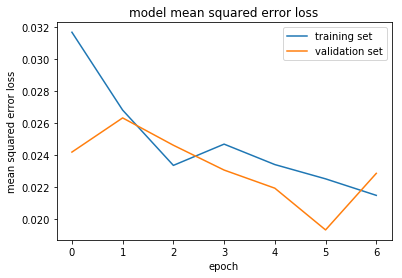

In [10]:
# Visualize Model Training History

from keras.models import Model
import matplotlib.pyplot as plt

#history_object = model.fit_generator(train_generator, samples_per_epoch =
#    len(train_samples), validation_data = 
#    validation_generator,
#    nb_val_samples = len(validation_samples), 
#    nb_epoch=5, verbose=1)

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [ ]:
import csv

with open('./data/driving_log.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        correction = 0.2 # paprameter to tune
        steering_center = float(row[3])
        steering_left = steering_center + correction
        steering_right= steering_center - correction
        
        img_center = process_image(np.asarray(Image.open(row[0])))
        img_left   = process_image(np.asarray(Image.open(row[1])))
        img_right  = process_image(np.asarray(Image.open(row[2])))
        
        car_images.extend(img_center, img_left, img_right)
        steering_angles.extend(steering_center, steering_left, steering_right)